### Endending map with flip method. 

In [17]:
import numpy as np
import pandas as pd               
from scipy.special import factorial
import fileinput
import matplotlib.pyplot as plt

1130/2

565.0

In [24]:
step_size = 0.0002669951063580811
map_shape = 1131
map_range = step_size*map_shape

x_in = y_in = np.arange(-np.floor(map_shape/2),np.floor(map_shape/2)+1)*step_size



In [25]:
def flip_expander(mapIn,xin,yin,r0,r_extended,*args):
    '''
    descr
    amp = amplification outside the r_real
    r0 = rad start value
    
    '''
    
    
    
    # amplification outside r_real, if amp=0, there is no amplification
    if len(args)<1:
        amp = 3
    else:
        amp= args[0]
    # fit zernike basis to real data for expantion
    if len(args)<2:
        order_zn = 3
    else:
        order_zn=2
    # resolution, how much [m] for each point in the map matrix
    
    # dx = xin[1]-xin[0]
    # dy = yin[1]-yin[0]

    # # number of points in x
    # # new x-axis, with same resolution but that goes now from xout = [-new_radius to new_radius]
    
    # neg_x = np.arange(0,r_extended + dx/2,dx)
    
    # pos_x = np.arange(-r_extended,0+ dx/2,dx)

    # neg_x =  neg_x[:-1]

    # xNew = np.concatenate((neg_x,pos_x),axis=0)

    # neg_y = np.arange(0,r_extended + dy/2,dy)
    
    # pos_y = np.arange(-r_extended,0+ dy/2,dy)

    # neg_y =  neg_y[:-1]

    # yNew = np.concatenate((neg_y,pos_y),axis=0)

    # # new number of points for x axis in the extendedmatrix
    # nx = len(xNew)
    # ny = len(yNew)
    # # num of points on x axis between the mapIn and the mapOut 
    # num_points = int(len(xNew)-len(xin))/2

    dx = xin[1]-xin[0]
    dy = yin[1]-yin[0]
    new0 = xin[0] - np.ceil( (r_extended + xin[0]) / dx )*dx
    nx = int(np.floor( ( xin[-1] + np.ceil( (r_extended - xin[-1]) / dx )*dx - new0 ) / dx ) + 1)
    xNew = np.arange(0,nx)*dx + new0
    new0 = yin[0] - np.ceil( (r_extended + yin[0]) / dy )*dy
    ny = int(np.floor( ( yin[-1] + np.ceil( (r_extended - yin[-1]) / dy )*dy - new0 ) / dy ) + 1)
    yNew = np.arange(0,ny)*dy + new0

    # create the skeleton for the exended map matrix
    # first we fill it with zeros, a matrix with the starting mirror map shape
    
    mapOut = np.zeros((nx,ny))
    #xg = x_grid (griglia)
    xg,yg = np.meshgrid(xin,yin)
    new_xg,new_yg = np.meshgrid(xNew,yNew)
    # new radius
    newRad2 = new_xg**2 + new_yg**2
    newRad = np.sqrt(newRad2)
    
    # copy old data from mapIn to mapOut in the center
    ####################################################
    mapOut[newRad2<=r0**2] = mapIn[xg**2+yg**2<=r0**2]
    
    idx = np.logical_and(newRad2 > r0**2, newRad2 <= r_extended**2)

    theta = np.arctan2(new_yg,new_xg)
    rrev= np.abs(2*r0-newRad)
    while(np.max(rrev)>r0):
         jnd = (rrev>r0)
         rrev[jnd] = np.abs(2*r0 - rrev[jnd])
    xgrev = np.array(np.floor(rrev*np.cos(theta)/dx + np.size(mapIn[0])/2 + 0.5) +1, dtype=int)
    ygrev = np.array(np.floor(rrev*np.cos(theta)/dx + np.size(mapIn[0])/2 + 0.5) +1, dtype=int)
    
    mapOut[idx] = mapIn[ygrev[idx],xgrev[idx]]*(1 + (newRad[idx]/r0-1)*amp)
    return  mapOut, xNew,yNew

    

In [26]:
map_=pd.read_csv('ETM05_S1_finesse.txt', header=None, sep=" ", skiprows=9).dropna(axis=1).values

mapout,xout,yout = flip_expander(map_,x_in,y_in,0.12,0.35)

In [11]:
header = f"""% Surface map
% Name: ETM05_S1 extended with map flip
% Type: phase both
% Size: {mapout.shape[0]} {mapout.shape[1]}
% Optical center (x,y): 
% Step size (x,y): {x_in[1]-x_in[0]} {y_in[1]-y_in[0]}
% Scaling: 1e-09
"""

np.savetxt(
    "ETM05_S1_extended_flip_35cm.txt",
    mapout,
    header=header,
)

In [12]:
mapout.shape

(2621, 2621)

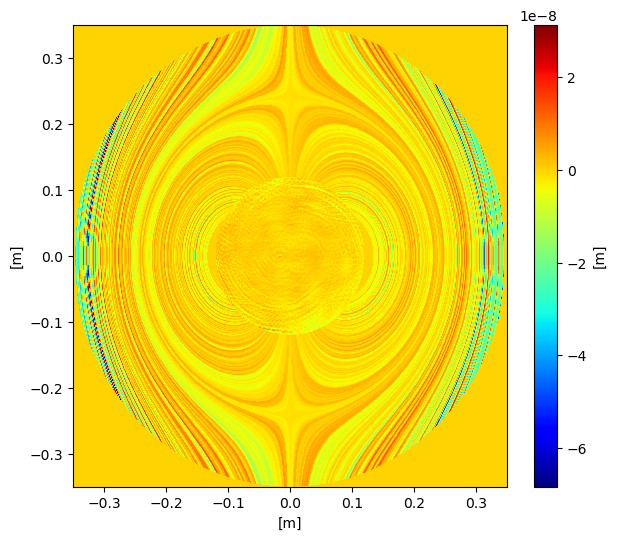

In [27]:
plt.figure(figsize=(7,6))
plt.pcolormesh(xout,yout,mapout*1e-8,cmap='jet')
plt.xlabel('[m]')
plt.ylabel('[m]')
# color bar
cb = plt.colorbar()                 
cb.set_label("[m]") 
plt.show()